In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# MWC2022

## Sleep Info

For the moment, I shall consider the self-reports for the sleep data.

In [2]:
from pandas import read_csv, to_datetime

In [3]:
experiment_info = read_csv('../data.nosync/mwc2022/all_experimento_info.csv', index_col=[0,1])
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].apply(to_datetime)
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].apply(to_datetime)
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].dt.tz_localize('Europe/Rome')
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].dt.tz_localize('Europe/Rome')

In [4]:
experiment_info[experiment_info['actual_bed_time'] < experiment_info['wake_up_time']]

index             bed_time latency  \
participant_id Date                                             
U09            2022-11-20    239  2022-11-20 01:45:00      15   
               2022-11-18    235  2022-11-18 00:15:00      15   
               2022-11-27    253  2022-11-27 03:05:00      10   
               2022-11-28    255  2022-11-28 00:33:00      21   
               2022-11-19    237  2022-11-19 00:55:00       5   
...                          ...                  ...     ...   
U10            2022-12-16    340  2022-12-16 00:30:59     5.0   
               2022-11-30    148  2022-11-30 00:28:00      10   
               2022-12-17    341  2022-12-17 00:40:58     5.0   
               2022-12-19    343  2022-12-19 00:32:54     3.0   
               2022-12-21    345  2022-12-21 03:00:17     0.0   

                                       wake_up_time awakening  \
participant_id Date                                             
U09            2022-11-20 2022-11-20 08:45:00+01:00         1   
               2022-11-18 2022-11-18 07:38:00+01:00         2   
               2022-11-27 2022-11-27 09:43:00+01:00         0   
               2022-11-28 2022-11-28 08:08:00+01:00         0   
               2022-11-19 2022-11-19 09:03:00+01:00         0   
...                                             ...       ...   
U10            2022-12-16 2022-12-16 08:18:13+01:00       3.0   
               2022-11-30 2022-11-30 07:06:00+01:00         2   
               2022-12-17 2022-12-17 08:20:10+01:00       0.0   
               2022-12-19 2022-12-19 06:40:08+01:00       0.0   
               2022-12-21 2022-12-21 07:34:36+01:00       0.0   

                          awakening_duration  \
participant_id Date                            
U09            2022-11-20                  2   
               2022-11-18                  2   
               2022-11-27                  0   
               2022-11-28                  0   
               2022-11-19                  0   
...                                      ...   
U10            2022-12-16           00:15:00   
               2022-11-30                NaN   
               2022-12-17           00:00:00   
               2022-12-19           00:00:00   
               2022-12-21           00:00:00   

                                                         disturbance_reasons  \
participant_id Date                                                            
U09            2022-11-20                                                NaN   
               2022-11-18                                feeling too hot (2)   
               2022-11-27                                                NaN   
               2022-11-28                                                NaN   
               2022-11-19                                                NaN   
...                                                                      ...   
U10            2022-12-16  My cat wanted to get outside so I had to open ...   
               2022-11-30                                                NaN   
               2022-12-17                                                  -   
               2022-12-19                                                  -   
               2022-12-21                                                  -   

                           recovery  sleep_quality morning_comments  \
participant_id Date                                                   
U09            2022-11-20       6.0            6.0              NaN   
               2022-11-18       7.0            8.0              NaN   
               2022-11-27       6.0            6.0              NaN   
               2022-11-28       7.0            7.0              NaN   
               2022-11-19       5.0            8.0              NaN   
...                             ...            ...              ...   
U10            2022-12-16       6.0            4.0                -   
               2022-11-30     

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"
# acc_data_base_path: str = "../data.nosync/mwc2022/filtered/*/ACC/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
# acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
# acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# ) 
# for file in tqdm(acc_data_paths, desc="Loading ACC data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     acc_data[side_name][user_name] = read_parquet(file)

acc_data = None
bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/19 [00:00<?, ?it/s]

525

In [6]:
physiological_data['EDA']['right']['U13']

mixed-EDA  phasic-EDA
session    timestamp                                              
2022-11-17 2022-11-17 00:29:38+01:00         -0.356251   -0.179237
           2022-11-17 00:29:38.250000+01:00  -0.333540   -0.179237
           2022-11-17 00:29:38.500000+01:00  -0.311632   -0.131899
           2022-11-17 00:29:38.750000+01:00  -0.295311   -0.090009
           2022-11-17 00:29:39+01:00         -0.284433   -0.067429
...                                                ...         ...
2022-12-22 2022-12-22 08:10:29.750000+01:00  -0.717994    3.498308
           2022-12-22 08:10:30+01:00         -0.727297    3.469839
           2022-12-22 08:10:30.250000+01:00  -0.732028    3.448389
           2022-12-22 08:10:30.500000+01:00  -0.736577    3.433078
           2022-12-22 08:10:30.750000+01:00  -0.740937    3.343001

[4410792 rows x 2 columns]

In [7]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [8]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [9]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [10]:
def remove_usr_from_idx(df: DataFrame, key: str) -> DataFrame:
    df = df.loc[IndexSlice[key, :], :]
    df.index = df.index.droplevel(0)
    return df
    
experiment_info_as_dict = {participant: remove_usr_from_idx(df=experiment_info, key=participant)
                           for participant in list(experiment_info.index.get_level_values(0).unique())}

In [11]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [12]:
eda_data = physiological_data['EDA']

In [13]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [14]:
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

In [15]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # this method gives 0 if the person is awake and 1 if the person is
    if (start < info["actual_bed_time"] and end < info["actual_bed_time"]) or (
        start > info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return 0
    elif (start < info["actual_bed_time"] and end > info["actual_bed_time"]) or (
        start < info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in users:
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    sessions = list(
        set(data_left.index.get_level_values(0).unique())
        & set(data_right.index.get_level_values(0).unique())
    )
    morning_survey_sessions = (
        experiment_info.loc[IndexSlice[user, :], :].index.get_level_values(1).unique()
    )

    sessions_all = list(set(sessions) & set(morning_survey_sessions))

    for session in tqdm(sessions_all, desc=f"Splitting {user=}. Sessions progress:"):
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info.loc[session, :]

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


Splitting user='U10'. Sessions progress::   0%|          | 0/7 [00:00<?, ?it/s]

Splitting user='U06'. Sessions progress::   0%|          | 0/5 [00:00<?, ?it/s]

Splitting user='U01'. Sessions progress::   0%|          | 0/10 [00:00<?, ?it/s]

Splitting user='U04'. Sessions progress::   0%|          | 0/11 [00:00<?, ?it/s]

Splitting user='U09'. Sessions progress::   0%|          | 0/19 [00:00<?, ?it/s]

Splitting user='U02'. Sessions progress:: 0it [00:00, ?it/s]

Splitting user='U13'. Sessions progress::   0%|          | 0/33 [00:00<?, ?it/s]

Splitting user='U03'. Sessions progress::   0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

In [44]:
values_left = [el for el in values_left if el.shape[0] == 2400]
labels_left = [label for label, el in zip(labels_left, values_left) if el.shape[0] == 2400]
groups_left = [group for group, el in zip(groups_left, values_left) if el.shape[0] == 2400]
values_right = [el for el in values_right if el.shape[0] == 2400]
labels_right = [label for label, el in zip(labels_right, values_right) if el.shape[0] == 2400]
groups_right = [group for group, el in zip(groups_right, values_right) if el.shape[0] == 2400]

1    4006
0    1012
dtype: int64
1    79.832603
0    20.167397
dtype: float64


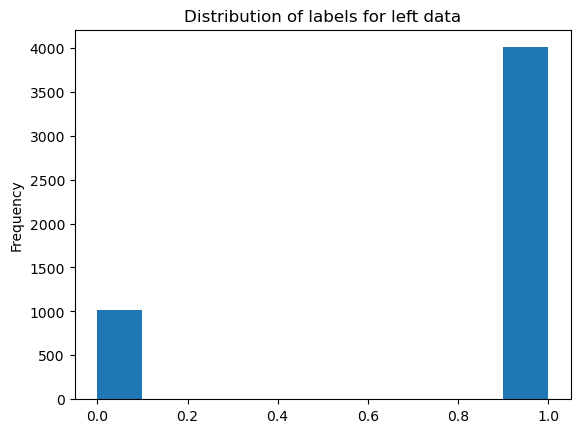

In [45]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

1    4063
0    1020
dtype: int64
1    79.93311
0    20.06689
dtype: float64


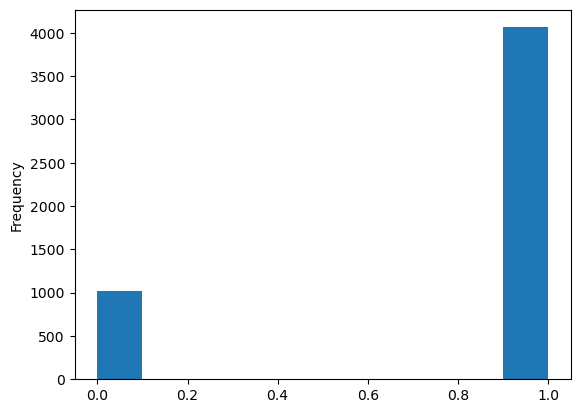

In [46]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [47]:
from numpy import stack

features_left: ndarray = stack(values_left)
features_right: ndarray = stack(values_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

In [48]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(5018, 2400)
labels_left.shape=(5018,)
groups_left.shape=(5018,)


## ML Prediction

In [49]:
from typing import Callable
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)

def resampling(df: DataFrame, resampling_method: BaseUnderSampler = RandomUnderSampler, random_state: int = 42) -> DataFrame:
    x = df.drop(columns=["label"], inplace=False).values
    y = df["label"].values
    cc = resampling_method(random_state=random_state)
    x_resampled, y_resampled = cc.fit_resample(x, y)
    result = DataFrame(x_resampled)
    result['label'] = y_resampled
    return result

## 5-fold CV

In [54]:
from sklearn.model_selection import KFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
def run_cv_ml(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values


    folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    return pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

#### LX v LX

In [55]:
run_cv_ml(features_left, labels_left, groups_left)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 16.82it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                    0.76              0.76    0.76     0.76   
RandomForestClassifier            0.76              0.76    0.76     0.76   
SVC                               0.75              0.76    0.76     0.75   
NuSVC                             0.75              0.75    0.75     0.75   
ExtraTreesClassifier              0.75              0.75    0.75     0.75   
XGBClassifier                     0.75              0.75    0.75     0.75   
CalibratedClassifierCV            0.75              0.75    0.75     0.75   
KNeighborsClassifier              0.74              0.74    0.74     0.74   
AdaBoostClassifier                0.74              0.74    0.74     0.74   
LogisticRegression                0.74              0.74    0.74     0.74   
LinearSVC                         0.74              0.74    0.74     0.73   
LabelPropagation                  0.73              0.73    0.73     0.73   
RidgeClassifierCV                 0.73              0.73    0.73     0.73   
LabelSpreading                    0.73              0.73    0.73     0.73   
LinearDiscriminantAnalysis        0.73              0.73    0.73     0.72   
RidgeClassifier                   0.73              0.73    0.73     0.72   
SGDClassifier                     0.73              0.73    0.73     0.72   
BaggingClassifier                 0.73              0.73    0.73     0.73   
BernoulliNB                       0.70              0.70    0.70     0.70   
NearestCentroid                   0.69              0.69    0.69     0.68   
DecisionTreeClassifier            0.67              0.67    0.67     0.67   
ExtraTreeClassifier               0.67              0.67    0.67     0.67   
Perceptron                        0.67              0.67    0.67     0.65   
GaussianNB                        0.67              0.67    0.67     0.65   
PassiveAggressiveClassifier       0.65              0.66    0.66     0.64   
QuadraticDiscriminantAnalysis     0.65              0.65    0.65     0.64   
DummyClassifier                   0.49              0.50    0.50     0.32   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                      0.48           0.01              0.01   
RandomForestClassifier              0.24           0.01              0.01   
SVC                                 0.06           0.01              0.01   
NuSVC                               0.07           0.01              0.01   
ExtraTreesClassifier                0.12           0.01              0.01   
XGBClassifier                       0.10           0.01              0.01   
CalibratedClassifierCV              0.26           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
AdaBoostClassifier                  0.10           0.00              0.00   
LogisticRegression                  0.01           0.01              0.01   
LinearSVC                           0.07           0.01              0.01   
LabelPropagation                    0.03           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
LabelSpreading                      0.04           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
SGDClassifier                       0.01           0.01              0.01   
BaggingClassifier                   0.07           0.01              0.01   
BernoulliNB                         0.00           0.01              0.01   
NearestCentroid           

#### RX vs RX

In [56]:
run_cv_ml(features_right, labels_right, groups_right)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 14.89it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LGBMClassifier                    0.72              0.72    0.72     0.72   
RandomForestClassifier            0.72              0.72    0.72     0.72   
ExtraTreesClassifier              0.72              0.72    0.72     0.72   
XGBClassifier                     0.72              0.72    0.72     0.71   
AdaBoostClassifier                0.71              0.71    0.71     0.71   
NuSVC                             0.71              0.71    0.71     0.70   
SVC                               0.70              0.70    0.70     0.70   
BaggingClassifier                 0.70              0.70    0.70     0.70   
LogisticRegression                0.69              0.69    0.69     0.69   
KNeighborsClassifier              0.69              0.69    0.69     0.69   
CalibratedClassifierCV            0.69              0.69    0.69     0.68   
LinearSVC                         0.69              0.69    0.69     0.68   
LinearDiscriminantAnalysis        0.68              0.68    0.68     0.67   
RidgeClassifier                   0.68              0.68    0.68     0.67   
RidgeClassifierCV                 0.68              0.68    0.68     0.67   
LabelPropagation                  0.68              0.68    0.68     0.68   
LabelSpreading                    0.68              0.68    0.68     0.67   
SGDClassifier                     0.66              0.66    0.66     0.65   
DecisionTreeClassifier            0.65              0.65    0.65     0.65   
ExtraTreeClassifier               0.64              0.64    0.64     0.64   
BernoulliNB                       0.63              0.63    0.63     0.62   
QuadraticDiscriminantAnalysis     0.63              0.62    0.62     0.61   
Perceptron                        0.62              0.62    0.62     0.62   
GaussianNB                        0.62              0.62    0.62     0.59   
NearestCentroid                   0.61              0.61    0.61     0.59   
PassiveAggressiveClassifier       0.60              0.60    0.60     0.58   
DummyClassifier                   0.49              0.50    0.50     0.32   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LGBMClassifier                      0.50           0.01              0.01   
RandomForestClassifier              0.25           0.01              0.01   
ExtraTreesClassifier                0.13           0.01              0.01   
XGBClassifier                       0.10           0.01              0.01   
AdaBoostClassifier                  0.10           0.01              0.01   
NuSVC                               0.10           0.01              0.01   
SVC                                 0.07           0.01              0.01   
BaggingClassifier                   0.07           0.01              0.01   
LogisticRegression                  0.01           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
CalibratedClassifierCV              0.27           0.01              0.01   
LinearSVC                           0.07           0.01              0.01   
LinearDiscriminantAnalysis          0.01           0.01              0.01   
RidgeClassifier                     0.01           0.01              0.01   
RidgeClassifierCV                   0.01           0.01              0.01   
LabelPropagation                    0.03           0.00              0.00   
LabelSpreading                      0.04           0.01              0.00   
SGDClassifier                       0.01           0.03              0.03   
DecisionTreeClassifier              0.01           0.01              0.01   
ExtraTreeClassifier       

#### LX vs RX

In [57]:
def local_resampling(x, y, groups, resampling_method: BaseUnderSampler = RandomUnderSampler):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values
    return x_resampled, y_resampled, groups

In [58]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:02<00:00, 11.43it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.70,0.70,0.70,0.70,0.21
AdaBoostClassifier,0.69,0.69,0.69,0.69,0.13
SVC,0.69,0.69,0.69,0.69,0.20
XGBClassifier,0.69,0.69,0.69,0.69,0.12
RandomForestClassifier,0.68,0.68,0.68,0.68,0.31
LogisticRegression,0.68,0.68,0.68,0.68,0.01
CalibratedClassifierCV,0.68,0.68,0.68,0.68,0.33
ExtraTreesClassifier,0.68,0.68,0.68,0.68,0.16
LGBMClassifier,0.68,0.68,0.68,0.68,0.59


#### RX vs LX

In [59]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:02<00:00, 10.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.74,0.74,0.74,0.74,0.23
RandomForestClassifier,0.73,0.73,0.73,0.73,0.32
LogisticRegression,0.73,0.73,0.73,0.73,0.01
CalibratedClassifierCV,0.72,0.72,0.72,0.72,0.34
LGBMClassifier,0.72,0.72,0.72,0.72,0.60
LinearSVC,0.72,0.72,0.72,0.72,0.09
RidgeClassifierCV,0.72,0.72,0.72,0.71,0.01
RidgeClassifier,0.72,0.72,0.72,0.71,0.01
LinearDiscriminantAnalysis,0.72,0.72,0.72,0.71,0.01


## 5-fold CV - different seeds

In [49]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed


def run_cv_ml_multiple_seeds(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 10
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    set_numpy_seed(666)
    n_seeds_to_test_folds: int = 10
    random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

    for random_state_folds in tqdm(
        random_states_folds, desc="Random states folds progress:", colour="blue"
    ):
        for random_state_classifier in tqdm(
            random_states_classifiers,
            desc="Random states classifiers progress:",
            colour="green",
        ):
            # NOTE: the fold generation should be fixed, to limit the accuracy
            # be due exclusively to starting confitions in the algorithm
            folds = StratifiedKFold(
                n_splits=5, random_state=random_state_folds, shuffle=True
            ).split(x_resampled, y_resampled)
            # TODO: we should iterate over different random states for the fold
            # generation as well, but independent from the random seeds for the algorithm
            # all_models = []
            # for train_index, test_index in folds:
            #     x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            #     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            #     clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            #     models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            #     all_models.append(models)
            from joblib import Parallel, delayed

            def run_fold(train_index, test_index):
                x_train, x_test = x_resampled[train_index], x_resampled[test_index]
                y_train, y_test = y_resampled[train_index], y_resampled[test_index]
                clf = LazyClassifier(
                    predictions=True, random_state=random_state_classifier
                )
                models, predictions = clf.fit(x_train, x_test, y_train, y_test)
                return models

            all_models = Parallel(n_jobs=-1)(
                delayed(run_fold)(train_index, test_index)
                for train_index, test_index in folds
            )

            averages = (
                pd.concat(all_models)
                .groupby(level=0)
                .mean()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_deviations = (
                pd.concat(all_models)
                .groupby(level=0)
                .std()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_errors = standard_deviations / 5**0.5
            results.append(
                pd.concat(
                    [averages, standard_errors],
                    axis=1,
                    keys=["Average", "Standard error"],
                )
            )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [51]:
result = run_cv_ml_multiple_seeds(features_left, labels_left, groups_left)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 44.28it/s]

100%|██████████| 29/29 [00:00<00:00, 46.14it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.34it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.26it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.17it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.30it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]



Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.99it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.12it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.71it/s]


In [53]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7653            0.7652  0.7652   0.7648   
RandomForestClassifier          0.7592            0.7591  0.7591   0.7587   
LGBMClassifier                  0.7504            0.7504  0.7504   0.7500   
XGBClassifier                   0.7410            0.7410  0.7410   0.7405   
BaggingClassifier               0.7401            0.7401  0.7401   0.7395   
AdaBoostClassifier              0.7192            0.7192  0.7192   0.7185   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
LabelPropagation                0.7178            0.7178  0.7178   0.7173   
KNeighborsClassifier            0.7177            0.7177  0.7177   0.7173   
NuSVC                           0.7101            0.7101  0.7101   0.7093   
DecisionTreeClassifier          0.7074            0.7074  0.7074   0.7069   
SVC                             0.6958            0.6958  0.6958   0.6953   
ExtraTreeClassifier             0.6867            0.6867  0.6867   0.6862   
LogisticRegression              0.6376            0.6376  0.6376   0.6369   
CalibratedClassifierCV          0.6373            0.6373  0.6373   0.6367   
RidgeClassifierCV               0.6345            0.6344  0.6344   0.6338   
LinearSVC                       0.6324            0.6324  0.6324   0.6317   
RidgeClassifier                 0.6299            0.6299  0.6299   0.6293   
LinearDiscriminantAnalysis      0.6271            0.6270  0.6270   0.6264   
NearestCentroid                 0.6253            0.6253  0.6253   0.6246   
BernoulliNB                     0.6216            0.6216  0.6216   0.6198   
SGDClassifier                   0.5810            0.5810  0.5810   0.5656   
Perceptron                      0.5598            0.5598  0.5598   0.5439   
PassiveAggressiveClassifier     0.5592            0.5591  0.5591   0.5314   
GaussianNB                      0.5463            0.5463  0.5463   0.4666   
QuadraticDiscriminantAnalysis   0.5392            0.5393  0.5393   0.4784   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0742         0.0014            0.0014   
RandomForestClassifier            0.1099         0.0013            0.0013   
LGBMClassifier                    0.0346         0.0012            0.0012   
XGBClassifier                     0.0733         0.0013            0.0013   
BaggingClassifier                 0.0265         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0018            0.0018   
LabelSpreading                    0.0099         0.0014            0.0014   
LabelPropagation                  0.0076         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
NuSVC                             0.0164         0.0012            0.0012   
DecisionTreeClassifier            0.0064         0.0017            0.0017   
SVC                               0.0130         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0018            0.0018   
LogisticRegression                0.0063         0.0020            0.0020   
CalibratedClassifierCV            0.1115         0.0021            0.0021   
RidgeClassifierCV                 0.0045         0.0019            0.0019   
LinearSVC                         0.0296         0.0019            0.0019   
RidgeClassifier                   0.0044         0.0019            0.0019   
LinearDiscriminantAnalysis        0.0043         0.0019            0.0019   
NearestCentroid           

### RX vs RX

In [54]:
result = run_cv_ml_multiple_seeds(features_right, labels_right, groups_right)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.33it/s]

100%|██████████| 29/29 [00:00<00:00, 46.41it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 45.33it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.02it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.11it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.57it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.07it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.05it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.34it/s]

100%|██████████| 29/29 [00:00<00:00, 43.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.96it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.06it/s]


In [55]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8144            0.8144  0.8144   0.8141   
RandomForestClassifier          0.8134            0.8134  0.8134   0.8132   
LGBMClassifier                  0.8083            0.8083  0.8083   0.8081   
XGBClassifier                   0.8064            0.8064  0.8064   0.8062   
BaggingClassifier               0.7993            0.7993  0.7993   0.7989   
KNeighborsClassifier            0.7829            0.7829  0.7829   0.7827   
AdaBoostClassifier              0.7738            0.7738  0.7738   0.7735   
NuSVC                           0.7703            0.7703  0.7703   0.7699   
SVC                             0.7663            0.7663  0.7663   0.7659   
DecisionTreeClassifier          0.7624            0.7624  0.7624   0.7620   
LabelSpreading                  0.7592            0.7593  0.7593   0.7587   
LabelPropagation                0.7569            0.7569  0.7569   0.7564   
ExtraTreeClassifier             0.7427            0.7427  0.7427   0.7423   
CalibratedClassifierCV          0.7047            0.7047  0.7047   0.7040   
NearestCentroid                 0.7010            0.7010  0.7010   0.7004   
BernoulliNB                     0.6989            0.6989  0.6989   0.6982   
LinearDiscriminantAnalysis      0.6966            0.6966  0.6966   0.6961   
GaussianNB                      0.6961            0.6960  0.6960   0.6934   
LinearSVC                       0.6915            0.6914  0.6914   0.6908   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6908   
LogisticRegression              0.6914            0.6914  0.6914   0.6908   
RidgeClassifier                 0.6907            0.6907  0.6907   0.6901   
SGDClassifier                   0.6372            0.6372  0.6372   0.6294   
Perceptron                      0.6114            0.6114  0.6114   0.6019   
PassiveAggressiveClassifier     0.6103            0.6103  0.6103   0.5937   
QuadraticDiscriminantAnalysis   0.6078            0.6078  0.6078   0.5834   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0710         0.0012            0.0012   
RandomForestClassifier            0.1069         0.0014            0.0014   
LGBMClassifier                    0.0358         0.0014            0.0014   
XGBClassifier                     0.0702         0.0013            0.0013   
BaggingClassifier                 0.0258         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
AdaBoostClassifier                0.0541         0.0013            0.0013   
NuSVC                             0.0127         0.0017            0.0017   
SVC                               0.0113         0.0016            0.0016   
DecisionTreeClassifier            0.0065         0.0015            0.0015   
LabelSpreading                    0.0102         0.0015            0.0015   
LabelPropagation                  0.0077         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0017            0.0017   
CalibratedClassifierCV            0.1130         0.0017            0.0017   
NearestCentroid                   0.0040         0.0017            0.0017   
BernoulliNB                       0.0040         0.0017            0.0017   
LinearDiscriminantAnalysis        0.0043         0.0016            0.0016   
GaussianNB                        0.0039         0.0021            0.0021   
LinearSVC                         0.0296         0.0016            0.0016   
RidgeClassifierCV         

## LOSO

### Support

In [50]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [51]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
    
def run_same_side_classifications(x, y, folds):
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = RandomUnderSampler(random_state=42)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    # del x_with_folds_resampled
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [54]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
from joblib import Parallel, delayed


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method, random_state=random_state)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = resampling_method(random_state=random_state)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [55]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [02:48<00:00,  5.81s/it]


In [56]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
CalibratedClassifierCV          0.5135            0.5135  0.5135   0.4955   
DecisionTreeClassifier          0.5117            0.5117  0.5117   0.5098   
QuadraticDiscriminantAnalysis   0.5090            0.5090  0.5090   0.4382   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   
PassiveAggressiveClassifier     0.4987            0.4987  0.4987   0.4788   
GaussianNB                      0.4965            0.4965  0.4965   0.4620   
ExtraTreeClassifier             0.4961            0.4961  0.4961   0.4939   
LabelSpreading                  0.4956            0.4956  0.4956   0.4895   
BaggingClassifier               0.4954            0.4954  0.4954   0.4934   
LabelPropagation                0.4952            0.4952  0.4952   0.4891   
SGDClassifier                   0.4933            0.4933  0.4933   0.4761   
ExtraTreesClassifier            0.4907            0.4907  0.4907   0.4860   
RandomForestClassifier          0.4904            0.4904  0.4904   0.4853   
XGBClassifier                   0.4882            0.4882  0.4882   0.4834   
LinearSVC                       0.4873            0.4873  0.4873   0.4708   
Perceptron                      0.4855            0.4855  0.4855   0.4677   
KNeighborsClassifier            0.4852            0.4852  0.4852   0.4786   
RidgeClassifierCV               0.4782            0.4782  0.4782   0.4695   
LogisticRegression              0.4754            0.4754  0.4754   0.4717   
NuSVC                           0.4752            0.4752  0.4752   0.4635   
LGBMClassifier                  0.4704            0.4704  0.4704   0.4685   
RidgeClassifier                 0.4677            0.4677  0.4677   0.4628   
AdaBoostClassifier              0.4659            0.4659  0.4659   0.4643   
NearestCentroid                 0.4538            0.4538  0.4538   0.4392   
LinearDiscriminantAnalysis      0.4517            0.4517  0.4517   0.4498   
BernoulliNB                     0.4506            0.4506  0.4506   0.4379   
SVC                             0.4080            0.4080  0.4080   0.3890   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
CalibratedClassifierCV           30.7338         0.0073            0.0073   
DecisionTreeClassifier            3.9736         0.0043            0.0043   
QuadraticDiscriminantAnalysis     1.4772         0.0020            0.0020   
DummyClassifier                   0.1051         0.0000            0.0000   
PassiveAggressiveClassifier       0.2939         0.0096            0.0096   
GaussianNB                        0.1277         0.0072            0.0072   
ExtraTreeClassifier               0.1190         0.0039            0.0039   
LabelSpreading                    0.3809         0.0051            0.0051   
BaggingClassifier                19.7641         0.0038            0.0038   
LabelPropagation                  0.3539         0.0051            0.0051   
SGDClassifier                     0.5637         0.0093            0.0093   
ExtraTreesClassifier              1.1847         0.0035            0.0035   
RandomForestClassifier            4.1344         0.0035            0.0035   
XGBClassifier                    37.7210         0.0032            0.0032   
LinearSVC                         7.8377         0.0080            0.0080   
Perceptron                        0.1909         0.0106            0.0106   
KNeighborsClassifier              0.1701         0.0039            0.0039   
RidgeClassifierCV                 1.3924         0.0057            0.0057   
LogisticRegression                0.3863         0.0048            0.0048   
NuSVC                     

### Test with different seeds (RX vs RX)

In [57]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [02:39<00:00,  5.52s/it]


In [58]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
BernoulliNB                     0.5387            0.5387  0.5387   0.5249   
NearestCentroid                 0.5380            0.5380  0.5380   0.5194   
GaussianNB                      0.5310            0.5310  0.5310   0.4942   
NuSVC                           0.5290            0.5290  0.5290   0.5165   
RandomForestClassifier          0.5260            0.5260  0.5260   0.5240   
RidgeClassifierCV               0.5207            0.5207  0.5207   0.5075   
BaggingClassifier               0.5184            0.5184  0.5184   0.5142   
ExtraTreesClassifier            0.5152            0.5152  0.5152   0.5133   
KNeighborsClassifier            0.5141            0.5141  0.5141   0.5127   
LabelSpreading                  0.5119            0.5119  0.5119   0.4999   
AdaBoostClassifier              0.5110            0.5110  0.5110   0.5063   
LabelPropagation                0.5092            0.5092  0.5092   0.4974   
LGBMClassifier                  0.5089            0.5089  0.5089   0.5078   
RidgeClassifier                 0.5088            0.5088  0.5088   0.4972   
ExtraTreeClassifier             0.5082            0.5082  0.5082   0.5070   
DecisionTreeClassifier          0.5057            0.5057  0.5057   0.5047   
LogisticRegression              0.5043            0.5043  0.5043   0.4965   
XGBClassifier                   0.5018            0.5018  0.5018   0.5011   
QuadraticDiscriminantAnalysis   0.5016            0.5016  0.5016   0.3388   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   
LinearSVC                       0.4984            0.4984  0.4984   0.4802   
Perceptron                      0.4982            0.4982  0.4982   0.4778   
SGDClassifier                   0.4963            0.4963  0.4963   0.4763   
PassiveAggressiveClassifier     0.4959            0.4959  0.4959   0.4747   
SVC                             0.4796            0.4796  0.4796   0.4523   
LinearDiscriminantAnalysis      0.4793            0.4793  0.4793   0.4753   
CalibratedClassifierCV          0.4626            0.4626  0.4626   0.4478   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
BernoulliNB                       0.1231         0.0063            0.0063   
NearestCentroid                   0.1126         0.0065            0.0065   
GaussianNB                        0.1333         0.0071            0.0071   
NuSVC                             2.7733         0.0053            0.0053   
RandomForestClassifier            3.7143         0.0038            0.0038   
RidgeClassifierCV                 1.4400         0.0054            0.0054   
BaggingClassifier                16.8707         0.0033            0.0033   
ExtraTreesClassifier              1.1623         0.0034            0.0034   
KNeighborsClassifier              0.1742         0.0031            0.0031   
LabelSpreading                    0.3985         0.0031            0.0031   
AdaBoostClassifier               14.9939         0.0041            0.0041   
LabelPropagation                  0.3681         0.0030            0.0030   
LGBMClassifier                    8.9074         0.0031            0.0031   
RidgeClassifier                   0.3667         0.0060            0.0060   
ExtraTreeClassifier               0.1213         0.0032            0.0032   
DecisionTreeClassifier            3.2058         0.0033            0.0033   
LogisticRegression                0.3814         0.0050            0.0050   
XGBClassifier                    38.6345         0.0024            0.0024   
QuadraticDiscriminantAnalysis     1.5420         0.0003            0.0003   
DummyClassifier           

### Test with different seeds (LX vs RX)

In [59]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

 90%|████████▉ | 26/29 [01:08<00:03,  1.04s/it]

In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7154            0.7154  0.7154   0.7118   
NuSVC                           0.7020            0.7020  0.7020   0.6980   
LogisticRegression              0.7001            0.7001  0.7001   0.6933   
AdaBoostClassifier              0.6975            0.6975  0.6975   0.6923   
CalibratedClassifierCV          0.6975            0.6975  0.6975   0.6930   
LinearSVC                       0.6934            0.6934  0.6934   0.6838   
XGBClassifier                   0.6930            0.6930  0.6930   0.6881   
RidgeClassifierCV               0.6921            0.6921  0.6921   0.6814   
RidgeClassifier                 0.6910            0.6910  0.6910   0.6800   
LinearDiscriminantAnalysis      0.6905            0.6905  0.6905   0.6794   
ExtraTreesClassifier            0.6879            0.6879  0.6879   0.6823   
RandomForestClassifier          0.6871            0.6871  0.6871   0.6810   
LGBMClassifier                  0.6821            0.6821  0.6821   0.6762   
BaggingClassifier               0.6647            0.6647  0.6647   0.6613   
SGDClassifier                   0.6644            0.6644  0.6644   0.6539   
KNeighborsClassifier            0.6617            0.6617  0.6617   0.6560   
LabelSpreading                  0.6569            0.6569  0.6569   0.6511   
LabelPropagation                0.6539            0.6539  0.6539   0.6478   
BernoulliNB                     0.6493            0.6493  0.6493   0.6385   
NearestCentroid                 0.6431            0.6431  0.6431   0.6245   
GaussianNB                      0.6391            0.6391  0.6391   0.6140   
Perceptron                      0.6089            0.6089  0.6089   0.5864   
ExtraTreeClassifier             0.6087            0.6087  0.6087   0.6063   
PassiveAggressiveClassifier     0.6083            0.6083  0.6083   0.5771   
QuadraticDiscriminantAnalysis   0.6013            0.6013  0.6013   0.5774   
DecisionTreeClassifier          0.5983            0.5983  0.5983   0.5950   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0588         0.0095            0.0095   
NuSVC                             0.0760         0.0078            0.0078   
LogisticRegression                0.0073         0.0069            0.0069   
AdaBoostClassifier                0.1058         0.0085            0.0085   
CalibratedClassifierCV            0.2940         0.0076            0.0076   
LinearSVC                         0.0760         0.0078            0.0078   
XGBClassifier                     0.2072         0.0100            0.0100   
RidgeClassifierCV                 0.0047         0.0077            0.0077   
RidgeClassifier                   0.0046         0.0077            0.0077   
LinearDiscriminantAnalysis        0.0053         0.0077            0.0077   
ExtraTreesClassifier              0.1364         0.0100            0.0100   
RandomForestClassifier            0.2645         0.0100            0.0100   
LGBMClassifier                    0.0589         0.0097            0.0097   
BaggingClassifier                 0.0789         0.0089            0.0089   
SGDClassifier                     0.0070         0.0090            0.0090   
KNeighborsClassifier              0.0085         0.0093            0.0093   
LabelSpreading                    0.0522         0.0076            0.0076   
LabelPropagation                  0.0318         0.0080            0.0080   
BernoulliNB                       0.0041         0.0060            0.0060   
NearestCentroid           

### Test with different seeds (RX vs LX)

In [ ]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.94it/s]


In [ ]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LogisticRegression              0.7661            0.7661  0.7661   0.7634   
CalibratedClassifierCV          0.7626            0.7626  0.7626   0.7601   
RidgeClassifierCV               0.7625            0.7625  0.7625   0.7585   
LinearSVC                       0.7615            0.7615  0.7615   0.7581   
LinearDiscriminantAnalysis      0.7602            0.7602  0.7602   0.7561   
RidgeClassifier                 0.7602            0.7602  0.7602   0.7562   
SVC                             0.7557            0.7557  0.7557   0.7550   
RandomForestClassifier          0.7334            0.7334  0.7334   0.7302   
LGBMClassifier                  0.7277            0.7277  0.7277   0.7238   
SGDClassifier                   0.7221            0.7221  0.7221   0.7139   
NearestCentroid                 0.7210            0.7210  0.7210   0.7131   
ExtraTreesClassifier            0.7163            0.7163  0.7163   0.7131   
BernoulliNB                     0.7144            0.7144  0.7144   0.7095   
AdaBoostClassifier              0.7133            0.7133  0.7133   0.7100   
BaggingClassifier               0.7102            0.7102  0.7102   0.7076   
NuSVC                           0.6951            0.6951  0.6951   0.6934   
XGBClassifier                   0.6924            0.6924  0.6924   0.6859   
GaussianNB                      0.6829            0.6829  0.6829   0.6681   
LabelSpreading                  0.6763            0.6763  0.6763   0.6751   
LabelPropagation                0.6741            0.6741  0.6741   0.6728   
KNeighborsClassifier            0.6729            0.6729  0.6729   0.6694   
Perceptron                      0.6587            0.6587  0.6587   0.6426   
DecisionTreeClassifier          0.6582            0.6582  0.6582   0.6556   
PassiveAggressiveClassifier     0.6325            0.6325  0.6325   0.6049   
ExtraTreeClassifier             0.6219            0.6219  0.6219   0.6193   
QuadraticDiscriminantAnalysis   0.6154            0.6154  0.6154   0.5831   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LogisticRegression                0.0069         0.0091            0.0091   
CalibratedClassifierCV            0.3057         0.0093            0.0093   
RidgeClassifierCV                 0.0048         0.0089            0.0089   
LinearSVC                         0.0789         0.0091            0.0091   
LinearDiscriminantAnalysis        0.0053         0.0090            0.0090   
RidgeClassifier                   0.0046         0.0090            0.0090   
SVC                               0.0681         0.0079            0.0079   
RandomForestClassifier            0.2769         0.0083            0.0083   
LGBMClassifier                    0.0576         0.0084            0.0084   
SGDClassifier                     0.0074         0.0092            0.0092   
NearestCentroid                   0.0055         0.0078            0.0078   
ExtraTreesClassifier              0.1422         0.0084            0.0084   
BernoulliNB                       0.0041         0.0077            0.0077   
AdaBoostClassifier                0.1064         0.0084            0.0084   
BaggingClassifier                 0.0825         0.0073            0.0073   
NuSVC                             0.1145         0.0059            0.0059   
XGBClassifier                     0.2099         0.0080            0.0080   
GaussianNB                        0.0044         0.0066            0.0066   
LabelSpreading                    0.0531         0.0072            0.0072   
LabelPropagation          

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.